In [10]:
#This notebook is seperate from NB2 because of how long it takes to run the watershedding and calculations in that notebook on my laptop
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from skimage.feature import blob_dog
from skimage.segmentation import watershed
from skimage.color import label2rgb
from skimage.measure import regionprops
import regions as rg
import astropy.units as u
from astropy.nddata.utils import Cutout2D
import scipy.ndimage
import sys as os
import csv

plt.rcParams.update({'font.size': 20}) #Edits font size on plots


(726,)


Text(0, 0.5, 'Log Radius (pc)')

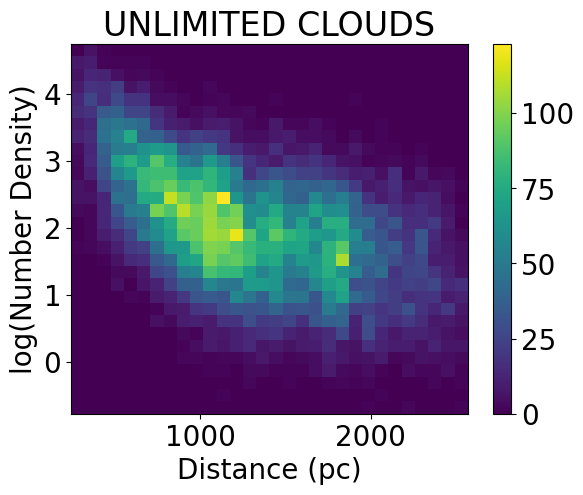

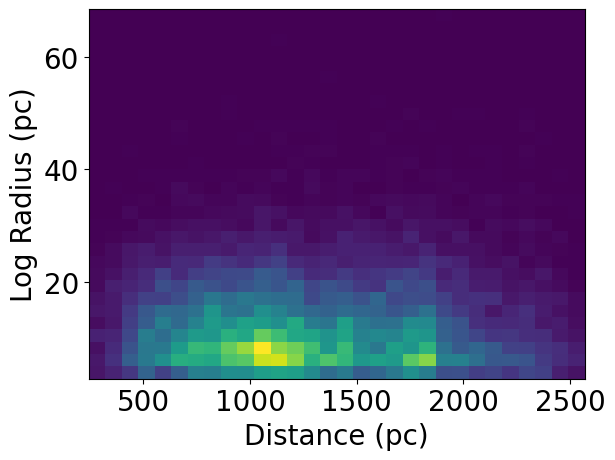

In [11]:
dist = np.loadtxt("combinedDist.csv", dtype=float, delimiter=",") #Load data from CSVs
density = np.loadtxt("combinedDens.csv", dtype=float, delimiter=",")
colDensity = np.loadtxt("combinedColDensity.csv", dtype=float, delimiter=",")
radii = np.loadtxt("combinedRadii.csv", dtype=float, delimiter=',')

HaDist, HaColMed, HaCol16, HaCol84, HaNumMed, HaNum16, HaNum84 = [], [], [], [], [], [], [] #We will store H-alpha densities in these lists

with open("M82_Ha_columns_ndensities.csv") as f: #Manual file reader
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        if row[0].startswith('#'): #Skip header
            continue
        else:
            HaDist.append(float(row[0])*1000) #Read the csv header to get index information
            HaColMed.append(float(row[1]))
            HaCol16.append(float(row[2]))
            HaCol84.append(float(row[3]))
            HaNumMed.append(np.log10(float(row[4])))
            HaNum16.append(np.log10(float(row[5])))
            HaNum84.append(np.log10(float(row[6])))
    f.close()

rDist, rMed, r16, r84 = [], [], [], [] #Store H-alpha radius information
with open("M82_Ha_cloud_radii.csv") as f:
    reader = csv.reader(f)

    for row in reader:
        if row[0].startswith('#'):
            continue
        else:
            rDist.append(float(row[0])*1000)
            rMed.append(float(row[1]))
            r16.append(float(row[2]))
            r84.append(float(row[3])) 
    f.close()

pADist, pAMed, pA16, pA84 = [], [], [], [] #Store H-alpha pressure information
with open("M82_Ha_pressures.csv") as f:
    reader = csv.reader(f)

    for row in reader:
        if row[0].startswith("#"):
            continue
        else:
            pADist.append(float(row[0])*1000)
            pAMed.append(float(row[1]))
            pA16.append(float(row[2]))
            pA84.append(float(row[3]))

co_clouds = np.genfromtxt('krieger2021_clouds_outflow.csv',delimiter=',') #Store CO information from Kriger 2021
co_dist = co_clouds[:,4] # kpc (I think)
co_rad = co_clouds[:,5] # pc (I think)
print(np.shape(co_rad))

xu_dist = [0.5,0.56,0.7,0.82,1.25,1.48,1.8,2] # kpc
xu_dist = [i*1000 for i in xu_dist]
xu_rad = [0.9,0.45,0.4,0.1,0.4,0.2,0.19,0.1] # pc

fig, ax = plt.subplots()
h, xbin, ybin, image = ax.hist2d(dist, np.log10(density), bins=(30, 30)) #Make the histogram
ax.set_xlabel("Distance (pc)")
ax.set_ylabel("log(Number Density)")
plt.title("Combined Histogram")
fig.colorbar(image)

fig, ax  = plt.subplots()
h, xbin, ybin, image = ax.hist2d(dist, radii, bins=(30,30))
ax.set_xlabel("Distance (pc)")
ax.set_ylabel("Log Radius (pc)")
#plt.savefig("NoRadiusRelation.png")


In [12]:
def medianLine(x, y, bins):
    '''
    Calculate median of each bin in a histogram. 

    Arguments: \n
    x- X axis data  \n
    y- Y axis data  \n 
    bins- X axis bin boundaries \n 

    Returns:
    medianX- list of x coordinates of points (midpoint of bin) \n
    medianY- median y values \n
    '''
    medianX=[]
    medianY=[]
    for i in range(np.size(bins)-1):
        lowX = bins[i]
        highX = bins[i+1]
        rangeMask = np.bitwise_and(lowX<=x, x<highX)
        medianX.append((lowX+highX)/2)
        medianY.append(np.median(y[rangeMask]))
    return medianX, medianY

def oneSigmaLine(x, y, bins):
    ''' 
    Calculate 16th and 84th percentile of a 2d histogram. Will give errors if fed nans.

    Arguments: \n
    x- X axis data \n
    y- Y axis data \n
    bins- X axis bin boundaries \n

    Returns: \n
    xOut- x coordinate of points (midpoint of bin)
    y16- y values of 16th percentile
    y84- y values of 84th percentile
    '''
    xOut = []
    y16 = []
    y84 = []
    for i in range(np.size(bins)-1):
        lowX = bins[i]
        highX = bins[i+1]
        rangeMask = np.bitwise_and(lowX<=x, x<highX)
        xOut.append((lowX+highX)/2)
        y16.append(np.percentile(y[rangeMask], 16))
        y84.append(np.percentile(y[rangeMask], 84))
    return xOut, y16, y84

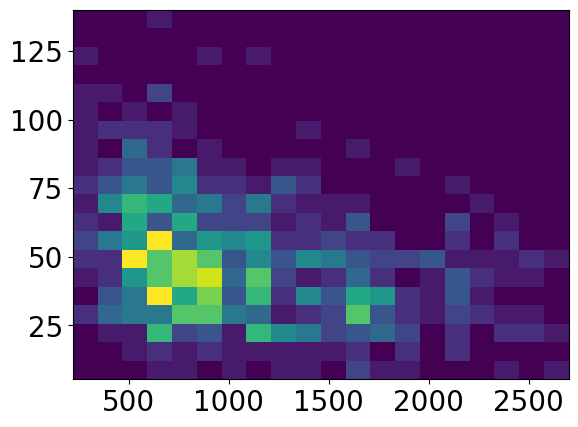

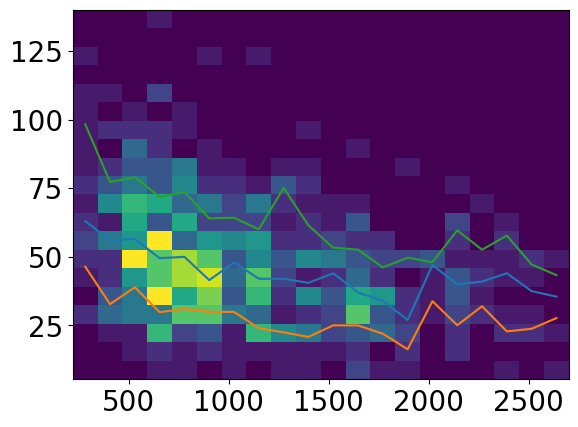

In [13]:
#All plotting

rmedx, rmedy = medianLine(dist, radii, xbin)
rmidx, ry16, ry84 = oneSigmaLine(dist, radii, xbin)

fig, ax = plt.subplots()
h, xbin, ybin, image = ax.hist2d(co_dist*1000, co_rad, bins=(20,20))
kriegerMedx, kriegerMedy = medianLine(co_dist*1000, co_rad, xbin)
kMidx, k16, k84 = oneSigmaLine(co_dist*1000, co_rad, xbin)
fig, ax = plt.subplots()
h, xbin, ybin, image = ax.hist2d(co_dist*1000, co_rad, bins=(20,20))
ax.plot(kriegerMedx, kriegerMedy)
ax.plot(kMidx, k16)
ax.plot(kMidx, k84)

Basically everything after this point is just plotting. The only non-plotting related code is calculating pressure in the cell that creates the pressure plot. Every other bit of code is purely plotting related

[5.741946, 5.6916458400000005, 6.022795, 5.6934228000000004, 6.1929836, 6.1112375199999995, 5.8419023999999995, 6.116774, 6.044541, 6.036022, 5.782807, 5.741946, 5.69842308, 5.68049832, 5.80923408, 5.915376520000001, 6.13726064, 5.753170800000001, 5.741946, 5.584758, 5.936035, 5.80048908, 5.67407228, 5.54376452, 5.38697416, 5.4760664, 5.224668, 4.9307368, 5.33496796, 5.20586064]
[19.463393840000002, 20.19897628, 19.753512, 18.70698776, 19.38970284, 19.75853952, 19.18194684, 19.161735559999986, 19.0639102, 18.917775, 19.32806592, 19.60870199999999, 18.68641876, 18.26495516, 18.840207919999997, 18.945884039999992, 19.649849560000003, 19.67738692, 19.83819344, 19.62433, 19.02610804, 19.73636256, 20.425785960000002, 18.647333679999992, 20.0094466, 18.194909119999995, 19.190170679999998, 19.1758506, 17.72849132, 15.763931359999999]


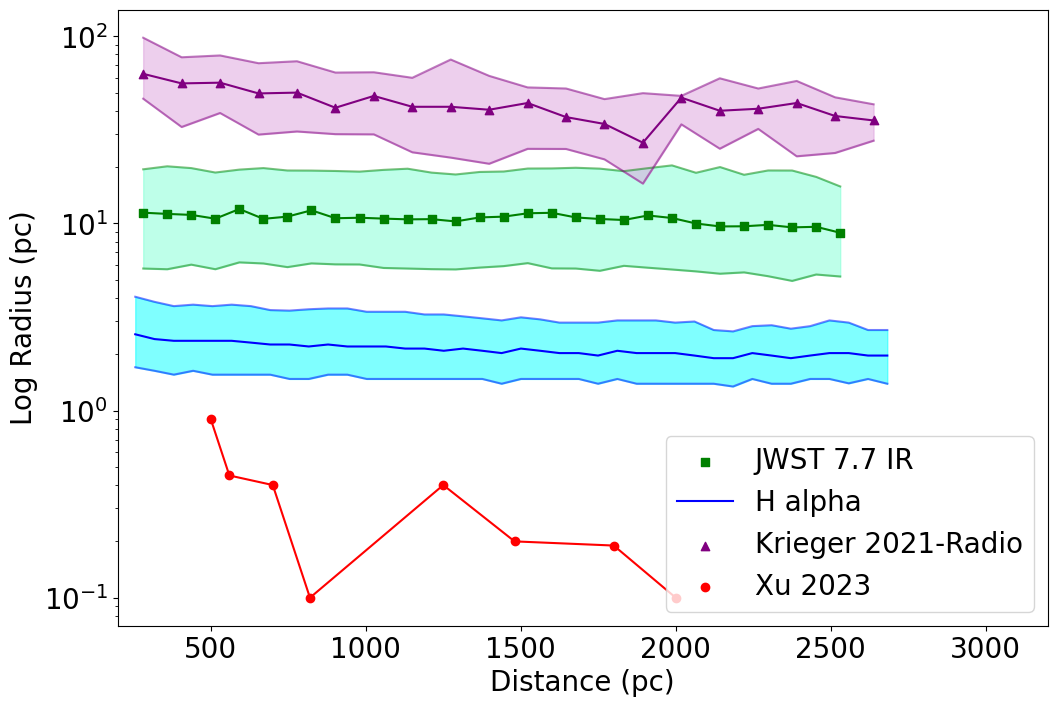

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel("Distance (pc)")
ax.set_ylabel("Log Radius (pc)")
ax.plot(rmedx, rmedy, color='green')
ax.scatter(rmedx, rmedy, color='green', label='JWST 7.7 IR', marker='s', zorder=3)
ax.plot(rmidx, ry16, color='green', alpha=0.5)
ax.plot(rmidx, ry84, color='green', alpha=0.5)
ax.fill_between(rmidx, ry16, ry84, color='aquamarine', alpha=0.5)
ax.plot(rDist, rMed, color='blue', label="H alpha")
ax.plot(rDist, r16, color='blue', alpha=0.5)
ax.plot(rDist, r84, color='blue', alpha=0.5)
ax.fill_between(rDist, r16, r84, color='cyan', alpha=0.5)
ax.plot(kriegerMedx, kriegerMedy, color='purple')
ax.scatter(kriegerMedx, kriegerMedy, color='purple', label='Krieger 2021-Radio', marker='^', zorder=3)
ax.plot(kMidx, k16, color='purple', alpha=0.5)
ax.plot(kMidx, k84, color='purple', alpha=0.5)
ax.fill_between(kMidx, k16, k84, color='plum', alpha=0.5)
ax.plot(xu_dist, xu_rad, color='red')
ax.scatter(xu_dist, xu_rad, color='red', label='Xu 2023', zorder=3)
ax.set_xlim(200, 3200)
ax.legend(loc="lower right")
ax.set_yscale("log")
#plt.savefig("MoreRadius.png")

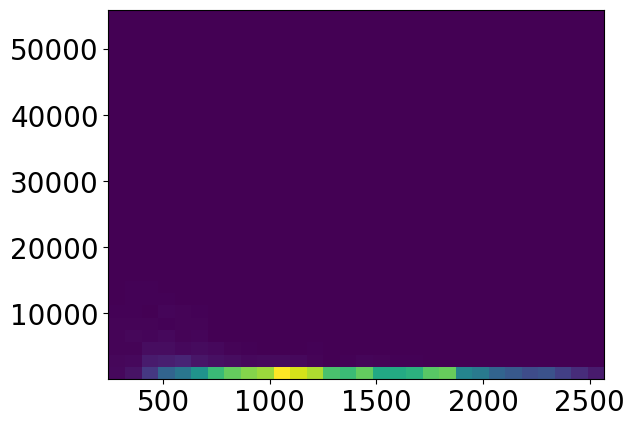

In [15]:
fig, ax = plt.subplots()
h, xbin, ybin, image = ax.hist2d(dist, density, bins=(30,30)) #Calculate bin range

medx, medy = medianLine(dist, density, xbin)
midx, y16, y84 = oneSigmaLine(dist, density, xbin)

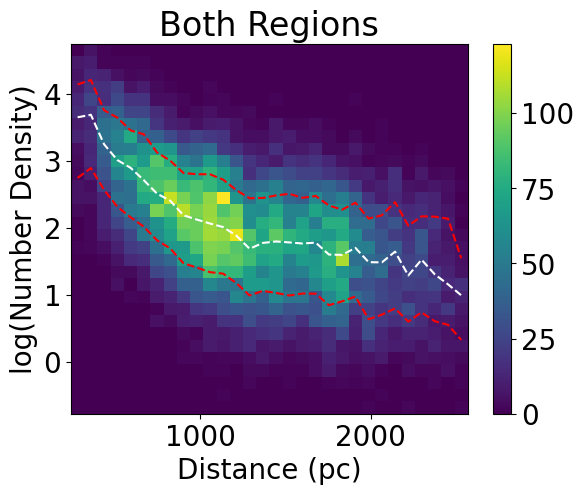

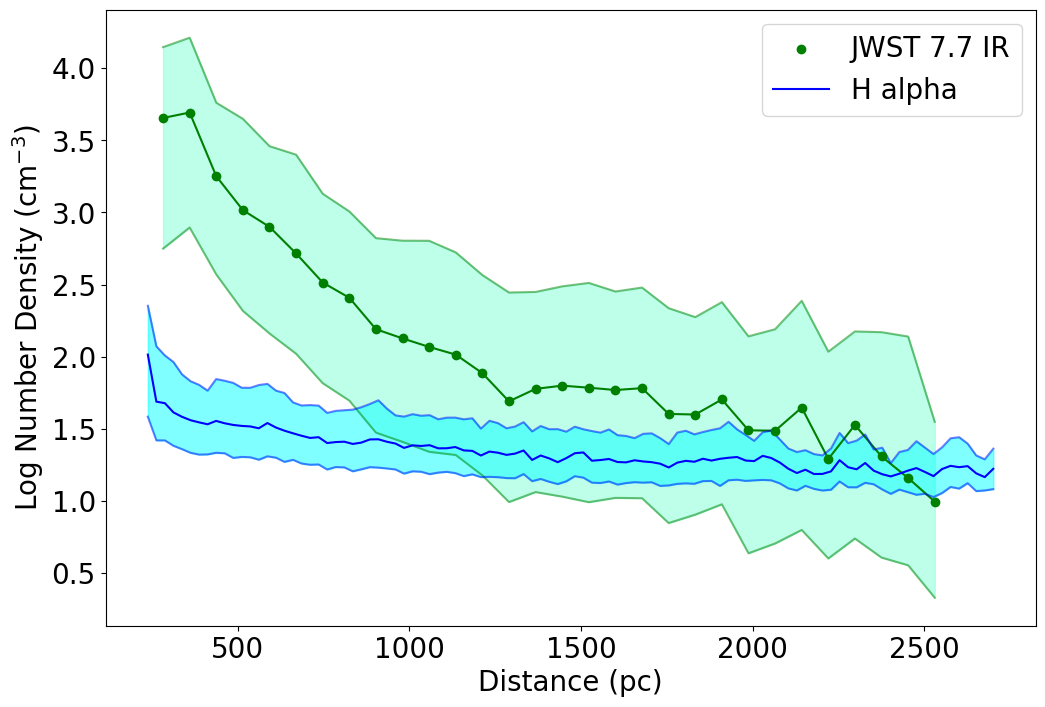

In [21]:
fig, ax = plt.subplots()
h, xbin, ybin, image = ax.hist2d(dist, np.log10(density), bins=(30, 30)) #Make the histogram
ax.plot(medx, np.log10(medy), 'w--')
ax.plot(midx, np.log10(y16), 'r--')
ax.plot(midx, np.log10(y84), 'r--')
ax.set_xlabel("Distance (pc)")
ax.set_ylabel("log(Number Density)")
plt.title("Both Regions")
fig.colorbar(image)
#plt.savefig("CompleteNumDensity.png")

fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlabel("Distance (pc)")
ax.set_ylabel("Log Number Density (cm$^{-3}$)")
ax.plot(medx, np.log10(medy), color='green')
ax.scatter(medx, np.log10(medy), color='green', label='JWST 7.7 IR', zorder=3)
ax.plot(midx, np.log10(y16), color='green', alpha=0.5)
ax.plot(midx, np.log10(y84), color='green', alpha=0.5)
ax.fill_between(midx, np.log10(y16), np.log10(y84), color='aquamarine', alpha=0.5)
ax.plot(HaDist, HaNumMed, color='blue', label="H alpha")
ax.plot(HaDist, HaNum16, color='blue', alpha=0.5)
ax.plot(HaDist, HaNum84, color='blue', alpha=0.5)
ax.fill_between(HaDist, HaNum16, HaNum84, color='cyan', alpha=0.5)
ax.legend()
#plt.savefig("NumberDensity.png")

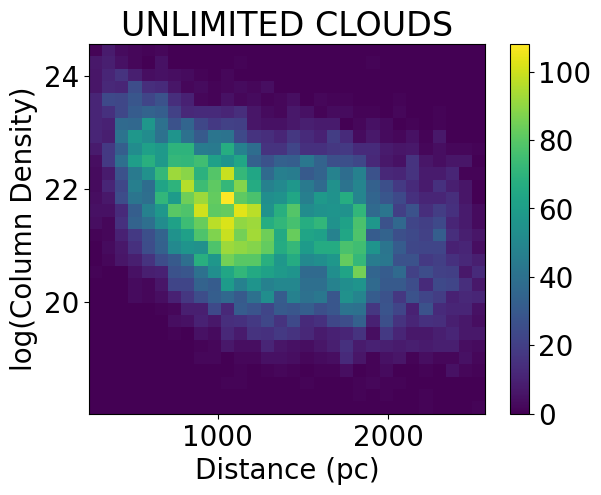

In [17]:
fig, ax = plt.subplots()
h, xbin, ybin, image = ax.hist2d(dist, np.log10(colDensity), bins=(30, 30)) #Make the histogram
ax.set_xlabel("Distance (pc)")
ax.set_ylabel("log(Column Density)")
plt.title("UNLIMITED CLOUDS")
fig.colorbar(image)

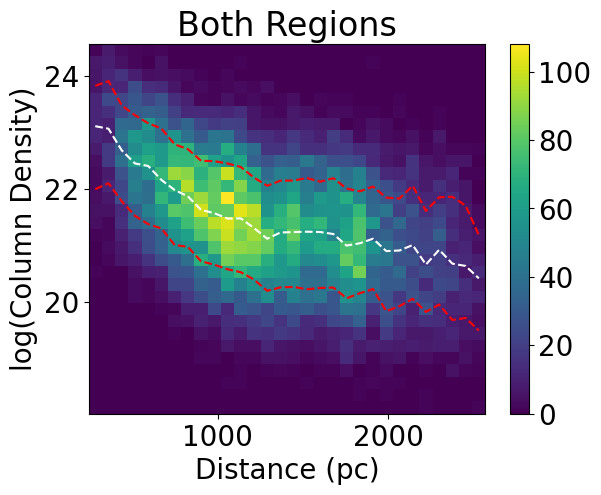

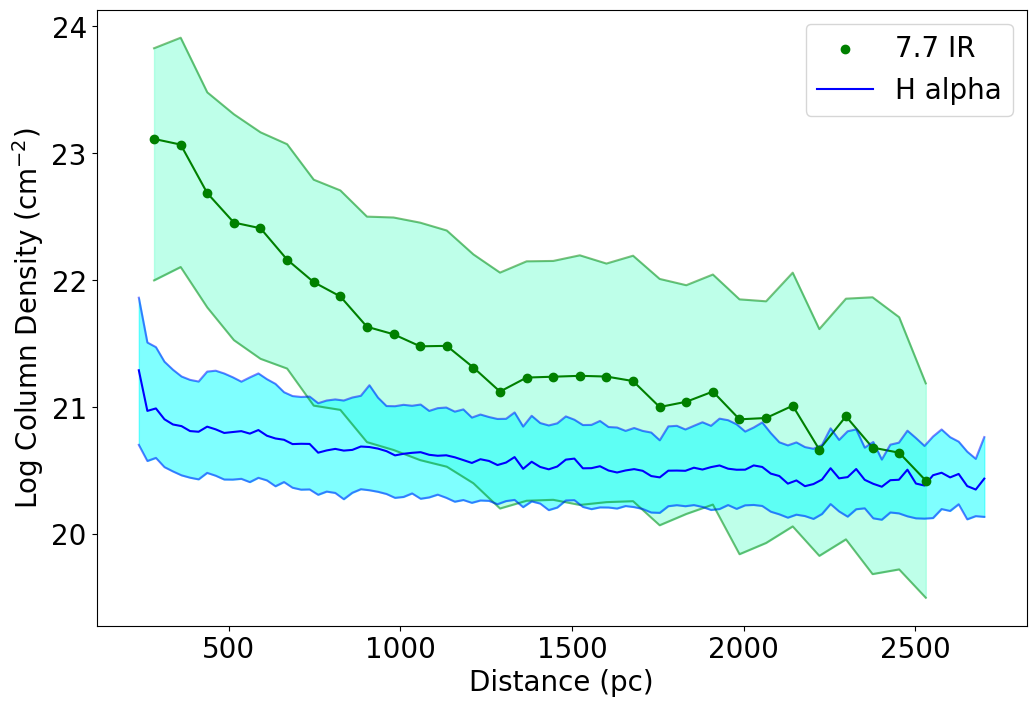

In [20]:
colmedx, colmedy = medianLine(dist, np.log10(colDensity), xbin)
colmidx, coly16, coly84 = oneSigmaLine(dist, np.log10(colDensity), xbin)

fig, ax = plt.subplots()
h, xbin, ybin, image = ax.hist2d(dist, np.log10(colDensity), bins=(30, 30)) #Make the histogram
ax.plot(colmedx, colmedy, 'w--')
ax.plot(colmidx, coly16, 'r--')
ax.plot(colmidx, coly84, 'r--')
ax.set_xlabel("Distance (pc)")
ax.set_ylabel("log(Column Density)")
plt.title("Both Regions")
fig.colorbar(image)
#plt.savefig("CompleteColDensity.png")

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel("Distance (pc)")
ax.set_ylabel("Log Column Density (cm$^{-2}$)")
ax.plot(colmedx, colmedy, color='green')
ax.scatter(colmedx, colmedy, color='green', label='7.7 IR', zorder=3)
ax.plot(colmidx, coly16, color='green', alpha=0.5)
ax.plot(colmidx, coly84, color='green', alpha=0.5)
ax.fill_between(colmidx, coly16, coly84, color='aquamarine', alpha=0.5)
ax.plot(HaDist, np.log10(HaColMed), color='blue', label="H alpha")
ax.plot(HaDist, np.log10(HaCol16), color='blue', alpha=0.5)
ax.plot(HaDist, np.log10(HaCol84), color='blue', alpha=0.5)
ax.fill_between(HaDist, np.log10(HaCol16), np.log10(HaCol84), color='aqua', alpha=0.5)
ax.legend()
plt.savefig("ColumnDensity.png")

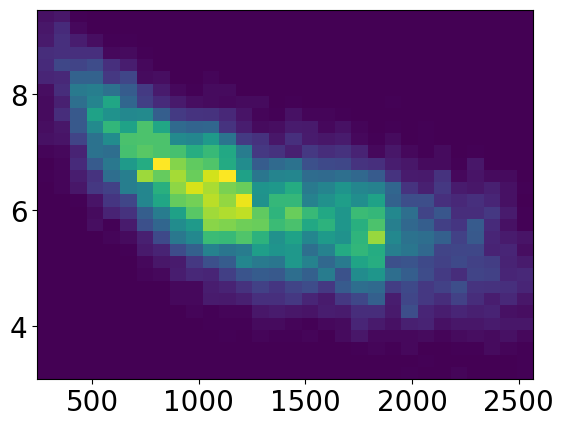

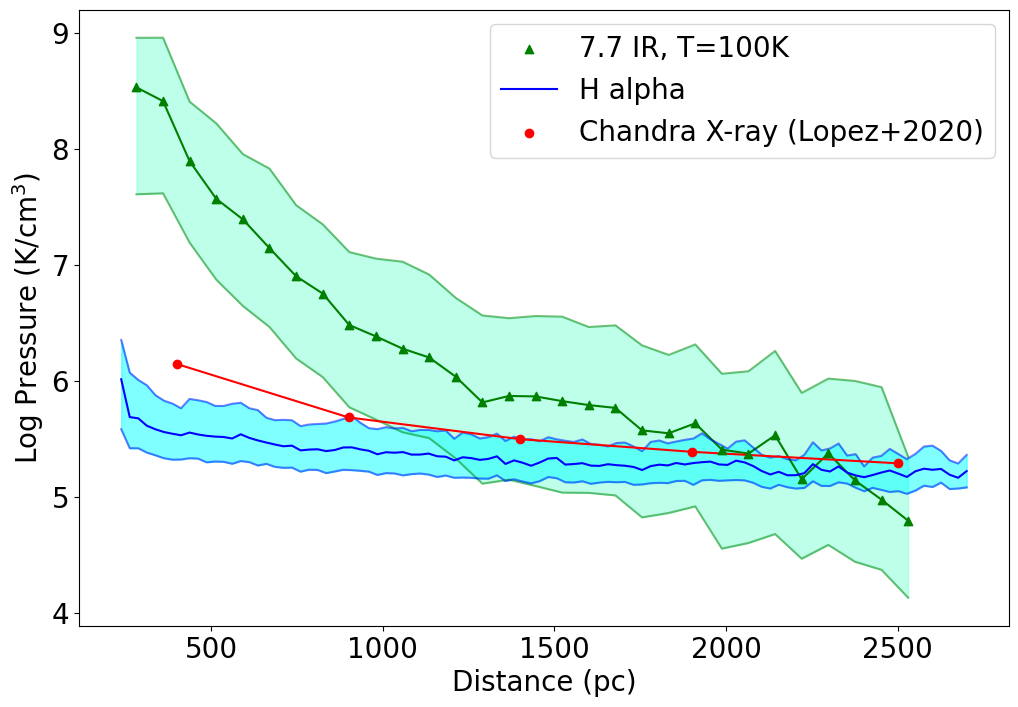

In [19]:
TEMP = 100
KB = 1.380649e-16 #erg/K
MH = 1.6735e-24 #grams

def distToVel(distance):
    v = 575*(distance**-0.56) #Distance in pc, v in km/s. Relation gotten from moment 2 map analysis in turbulence notebook.
    return v

pressure = []
disp = []
turbPressure = []
#This loop calculates turbulent pressure
for i in range(len(dist)):
    dispersion = distToVel(dist[i])*10**5 #Unit conversion from km/s->cm/s
    pTurb = (density[i]*MH*(dispersion)**2) #Mass Density * sigma^2
    pTot = (density[i]*TEMP*KB)+(pTurb) #Add them
    pressure.append(pTot/KB)
    turbPressure.append(pTurb/KB)
    disp.append(dispersion)

pressure = np.array(pressure)

testP = density*5000

fig, ax = plt.subplots()
h, xbin, ybin, image = ax.hist2d(dist, np.log10(pressure), bins=(30, 30)) 

pmedx, pmedy = medianLine(dist, pressure, bins=xbin)
pmidx, p16, p84 = oneSigmaLine(dist, pressure, bins=xbin)

testMX, testMY = medianLine(dist, testP, bins=xbin)

#Manually entered chandra data from Lopez 2020 paper
chandraDist = [2500, 1900, 1400, 900, 400, 400, 900, 1400, 1900, 2500]
chandraPressure = [1.6e5, 2.3e5, 2.3e5, 4.3e5, 1.5e6, 1.3e6, 5.4e5, 4.0e5, 2.6e5, 2.3e5]
chandraX = [2500, 1900, 1400, 900, 400]
chandraAvg = [1.95e5, 2.45e5, 3.15e5, 4.85e5, 1.4e6]

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel("Distance (pc)")
ax.set_ylabel("Log Pressure (K/cm$^{3}$)")
ax.plot(pmedx, np.log10(pmedy), color='green')
ax.scatter(pmedx, np.log10(pmedy), color='green', label="7.7 IR, T="+str(TEMP)+"K", marker="^", zorder=3)
ax.plot(pmidx, np.log10(p16), color='green', alpha=0.5)
ax.plot(pmidx, np.log10(p84), color='green', alpha=0.5)
ax.fill_between(pmidx, np.log10(p16), np.log10(p84), color='aquamarine', alpha=0.5)

ax.plot(pADist, np.log10(pAMed), color='blue', label="H alpha")
#ax.scatter(pADist, np.log10(pAMed), color="blue", label="H alpha", marker="s", zorder=3)
ax.plot(pADist, np.log10(pA16), color='blue', alpha=0.5)
ax.plot(pADist, np.log10(pA84), color='blue', alpha=0.5)
ax.fill_between(pADist, np.log10(pA16), np.log10(pA84), color='cyan', alpha=0.5)
ax.plot(chandraX, np.log10(chandraAvg), color='red')
ax.scatter(chandraX, np.log10(chandraAvg), color='red', label="Chandra X-ray (Lopez+2020)", zorder=3)
ax.legend()
plt.savefig("Pressure.png")